***
# BCI-IL WS 2018/2019 - Exercise Sheet #01
***

#### Sample Solution

This exercise sheet refers to lecture \#2. The dataset is taken from an ERP Speller experiment, similar to the one discussed in the lecture. The first two tasks are about basic visualizations of Event-Related Potentials (ERPs), and the third one is the implementation of a univariate measure of separability and its visualization.

In [2]:
% matplotlib inline

import numpy as np
import scipy as sp
from matplotlib import pyplot as plt

import bci_minitoolbox as bci

## Preparation: Loading Data

In [3]:
fname = 'erp_hexVPsag.npz'
cnt, fs, clab, mnt, mrk_pos, mrk_class, mrk_className = bci.load_data(fname)

## Exercise 1: Plotting ERPs  (5 points)

Plot the average ERPs corresponding to *target* and *nontarget* stimuli in the time interval -100 to 1000 ms for the channels Cz and PO7. This means that the average ERPs are class and channel-wise. <br>
In order to make the curves look reasonable, a so called 'baseline correction' should be performed: for each channel and trial, calculate the average across the prestimulus time interval -100 to 0 ms. This results in one value per channel and trial. Subtract this 'baseline' value from each (single channel/single trial) time course. 
The function `baseline` is provided in the `bci_minitoolbox`.
<font color=red>**It is recommended**</font> to have a look at the code of `bci.baseline`! It is three lines only, and shows, e.g., how to get the indices within an epoch that correspond to a given time interval. This will prove useful in future exercises.

(91, 55, 1200)
91 samples, 55 channels, 1200 epochen
(91, 55, 1200)
[ 1.32523237  0.84186222  0.20394514 -0.44959104 -0.64770704 -0.11008105
 -0.08048696 -0.69456435 -0.76197312 -0.16515894  0.53852278  0.39712879
  0.42261259  0.70046822  0.43740964  0.67498442  0.54181101  0.35273765
  0.73335055  0.49166547 -0.11912369 -0.55481448  0.4185023   0.91173715
 -0.84171275 -1.35056671 -0.87623919 -0.55563654  0.77691963  0.88707541
  0.53934484  1.30961327  1.28084124  0.93393272  0.75636817  0.67662854
  0.77609757  0.51221692 -0.14214132 -1.57252239 -3.02509904 -2.69134345
 -1.06695667 -0.11090311  0.428367    1.36880145  2.3897976   3.21514392
  3.78647429  4.31670176  3.97472559  3.14773516  2.81562369  1.70091292
  0.54838748  0.8500828   0.93311066  0.73910495  1.13698107  0.93393272
  0.94133124  1.7798305   2.43994314  2.34047411  1.86943483  1.76667757
  1.79873783  1.6071983   1.27590889  1.00874001  0.30834652 -0.36163083
 -0.07802079  0.03131294 -0.03362965  0.10776434  0.1570

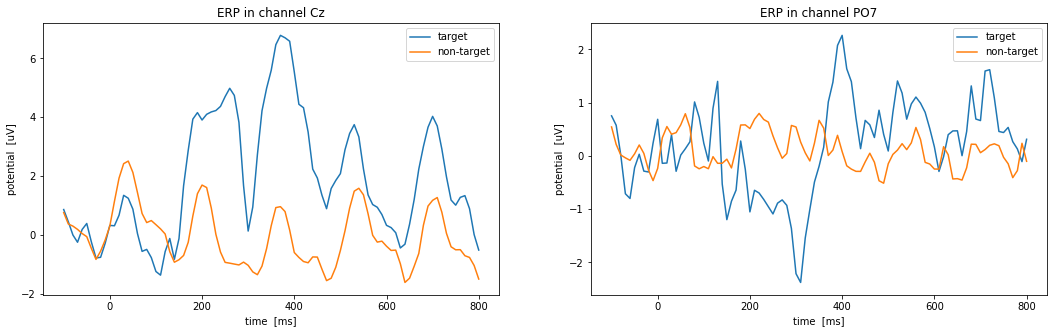

In [19]:
# Store given information in variables.
ival= [-100, 800]
ref_ival= [-100, 0]
chans = ['Cz', 'PO7']

# Segment continuous data into epochs:
epo, epo_t = bci.makeepochs(cnt, fs, mrk_pos, ival)
print(epo.shape)
print('91 samples, 55 channels, 1200 epochen')
# Baseline correction:
epo = bci.baseline(epo, epo_t, ref_ival)
print(epo.shape)

erp0 = np.mean(epo[:, :, mrk_class==0], axis=2)
erp1 = np.mean(epo[:, :, mrk_class==1], axis=2)

plt.figure(figsize=[18, 5])
for i, chan in enumerate(chans):
    # subplot 1 row for epo_t, 2 columns for channels
    plt.subplot(1, len(chans), i+1)
    chidx = clab.index(chan)
    plt.plot(epo_t, erp0[:, chidx], label=mrk_className[0])
    plt.plot(epo_t, erp1[:, chidx], label=mrk_className[1])
    plt.title('ERP in channel {}'.format(chan))
    plt.xlabel('time  [ms]')
    plt.ylabel('potential  [uV]')
    plt.legend()

## Exercise 2: Scalp Topographies of ERPs  (5 points)

Calculate the average potential separately for the classes *target* and *non-target* in the following time intervals [ms]: [160 200], [230 260], [300 320], and [380 430]. (This involves averaging over all trials of the respective class and averaging over all sample points in the respective time interval.)
Visualize the result as scalp topographies using the function `bci.scalpmap`, i.e., 4 maps for each class. <br>
**Note:** In order to make the maps look reasonable, do a *baseline correction* as in the previous task. To make the maps comparable, use a common scale for the colorbar (see help of `scalpmap`).

(91,)
(55, 1200)
(91,)
(55, 1200)
(91,)
(55, 1200)
(91,)
(55, 1200)


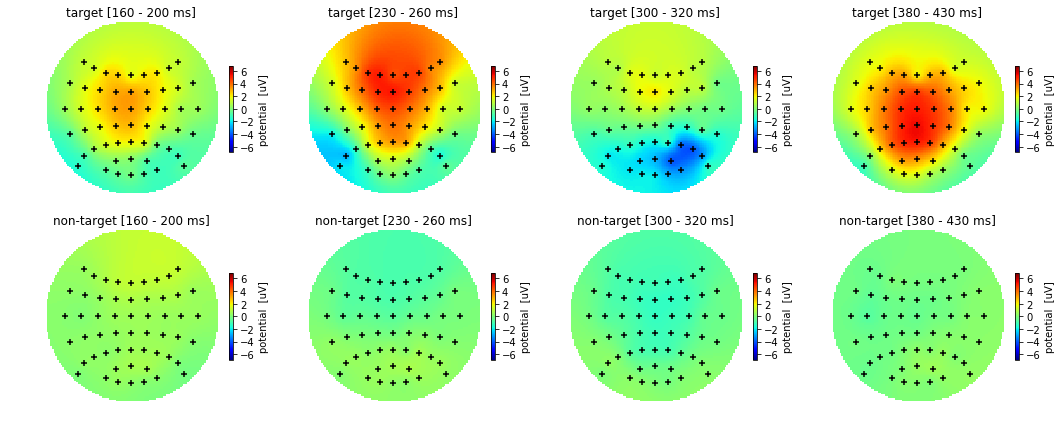

In [25]:
ival = [[160, 200], [230, 260], [300, 320], [380, 430]]
nIvals = len(ival) 

maxamp = np.vstack((abs(erp0), abs(erp1))).max()

plt.figure(figsize=(18, 7))
for k in range(nIvals):
    # in every epoch (time marker) say if interval is inside == true
    # returns true or false for each time marker inteval
    tidx = (ival[k][0] <= epo_t) & (epo_t <= ival[k][1])
    print(tidx.shape)
    scalp = np.mean( epo[ tidx, :, :], axis=0)
    print(scalp.shape)
    for ci in range(2):
        # subplot 2 rows, 4 columns, 1+0+0 or 1+1*4+0 
        plt.subplot(2, 4, 1 + ci*nIvals + k)
        erp_map = np.mean(scalp[ :, mrk_class==ci ], axis=1 )
        bci.scalpmap(mnt, erp_map, clim=(-maxamp,maxamp), cb_label='potential  [uV]')
        plt.title('{} [{} - {} ms]'.format(mrk_className[ci], ival[k][0], ival[k][1]))

## Exercise 3: Visualization with the Biserial Correlation Coefficient  (5 points)

Implement a function for the calculation of the signed `r^2`-value (see point-biserial correlation coefficient in BCI lecture \#02). From the given data set, extract epochs for the time interval [-100 600] ms relativ to each stimulus presentation.  Calculate for each channel and each point in time the signed `r^2`-value wrt. classes
*target* vs. *non-target* and visualize this (channel `x` time points) matrix (`pl.imshow`). Again, use 100 ms prestimulus for baseline correction.

In [26]:
def signed_r_square(epo, y):
    '''
    Synopsis:
        epo_r = signed_r_square(epo, y)
    Arguments:
        epo:    3D array of segmented signals (time x channels x epochs), 
                see makeepochs
        y:      labels with values 0 and 1 (1 x epochs)
    Output:
        epo_r:  2D array of signed r^2 values (time x channels)
    '''
    epo0 = epo[:, :, y==0]
    epo1 = epo[:, :, y==1]
    N1 = epo0.shape[2]
    N2 = epo1.shape[2]
    const = np.float(N1*N2) / ((N1+N2)**2)
    mudiff = epo0.mean(axis=2) - epo1.mean(axis=2)
    var = epo.var(axis=2)
    return np.sign(mudiff) * const * (mudiff)**2 / var

In [27]:
epo, epo_t = bci.makeepochs(cnt, fs, mrk_pos, [-100, 600])
epo = bci.baseline(epo, epo_t, [-100, 0])
epo_r = signed_r_square(epo, mrk_class)

max_r= abs(epo_r).max()
plt.figure(figsize=(18,6))
ext = (epo_t[0], epo_t[-1], epo.shape[1], 0)
plt.imshow(epo_r.T, extent=ext, aspect='auto', vmin=-epo_r.max(), vmax=epo_r.max(), interpolation='None', cmap='bwr')
plt.colorbar(shrink=0.9, label='signed r^2')
plt.title('biserial correlation coefficient T-NT')
plt.xlabel('time  [ms]')
plt.ylabel('channel')
selected_channels = ['Fz','FCz','Cz','CPz','Pz','POz','Oz']
idx_z = [clab.index(x) for x in selected_channels]
plt.yticks(idx_z, selected_channels);

IndexError: tuple index out of range